# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Test Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


Image dimensions: (128, 128, 3)


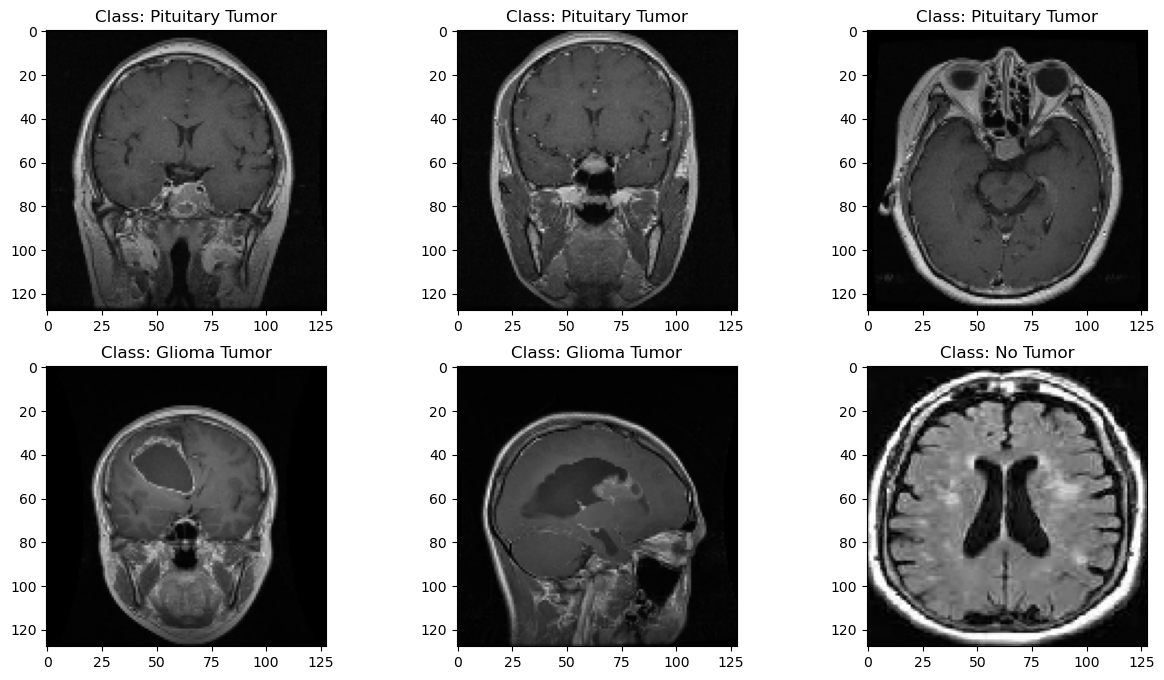

In [6]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'Glioma Tumor': 0, 'Meningioma Tumor': 1, 'No Tumor': 2, 'Pituitary Tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [52]:
# Extract data and labels from the generated batches on train set
data_train, labels_train = [], []
for _ in range(len(train_gen)):
    images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
    data_train.extend(images_train)
    labels_train.extend(batch_labels_train)

# Extract data and labels from the generated batches on test set
data_test, labels_test = [], []
for _ in range(len(test_gen)):
    images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
    data_test.extend(images_train)
    labels_test.extend(batch_labels_test)

# Extract data and labels from the generated batches on validation set
data_val, labels_val = [], []
for _ in range(len(val_gen)):
    images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
    data_val.extend(images_val)
    labels_val.extend(batch_labels_val)

# Flatten the image data
data_train_flat = np.array(data_train).reshape(len(data_train), -1)
data_test_flat = np.array(data_test).reshape(len(data_test), -1)
data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# Create Dataframes for each set. Keep class labels in order
df_train_data = pd.DataFrame(data_train_flat)
df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_train = pd.concat([df_train_data, df_train_labels], axis=1)

df_test_data = pd.DataFrame(data_test_flat)
df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_test = pd.concat([df_test_data, df_test_labels], axis=1)

df_val_data = pd.DataFrame(data_val_flat)
df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [53]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,49146,49147,49148,49149,49150,49151,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
1,0.933333,0.933333,0.933333,0.886275,0.886275,0.886275,1.000000,1.000000,1.000000,0.905882,...,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.0,0.0,1.0,0.0
2,0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,...,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


In [54]:
# Display the shape of each DataFrame
print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
print("Validation DataFrame shape:", df_val.shape)

Train DataFrame shape: (6946, 49156)
Test DataFrame shape: (1728, 49156)
Validation DataFrame shape: (1734, 49156)


Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Principal Component Analysis

In [55]:
from sklearn.decomposition import PCA

# Convert column names to strings
df_train.columns = df_train.columns.astype(str)
df_test.columns = df_test.columns.astype(str)
df_val.columns = df_val.columns.astype(str)

columns_drop = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

train_pca = df_train.drop(columns=columns_drop)
test_pca = df_test.drop(columns=columns_drop)
val_pca = df_val.drop(columns=columns_drop)

In [56]:
# Define variance to retain
variance = 0.95

# Instatiate PCA 
pca = PCA(variance)

# fit the PCA on train data
pca.fit(train_pca)

PCA(n_components=0.95)

In [57]:
# Transform the data
pca_data_train = pca.transform(train_pca)
pca_data_test = pca.transform(test_pca)
pca_data_val = pca.transform(val_pca)

In [58]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_labels = df_train[labels]
test_labels = df_test[labels]
val_labels = df_val[labels]

# SVM

In [59]:
# Convert one-hot encoded labels to integer labels
integer_train_labels = np.argmax(train_labels, axis=1)
integer_test_labels = np.argmax(test_labels, axis=1)

In [60]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X=pca_data_train, y=integer_train_labels)

SVC()

In [61]:
clf.score(X=pca_data_test, y=integer_test_labels)

0.24479166666666666

In [62]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(pca_data_test)
cm = confusion_matrix(integer_test_labels, y_pred, labels=range(len(labels)))

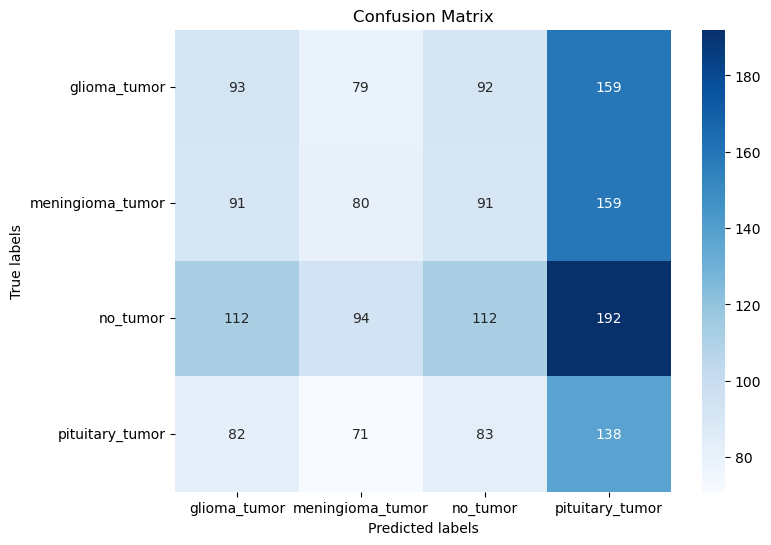

In [63]:
import seaborn as sns
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], yticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Convolutinal Base

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8388736   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,389,700
Trainable params: 8,389,700
Non-trainable params: 0
______________________________________________

Epoch 1/50


218/218 [==============================] - 11s 39ms/step - loss: 0.6013 - precision: 0.8309 - recall: 0.6926 - accuracy: 0.7699 - val_loss: 0.2412 - val_precision: 0.9254 - val_recall: 0.9020 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.1480 - precision: 0.9502 - recall: 0.9441 - accuracy: 0.9479 - val_loss: 0.1644 - val_precision: 0.9469 - val_recall: 0.9360 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0470 - precision: 0.9893 - recall: 0.9889 - accuracy: 0.9892 - val_loss: 0.1263 - val_precision: 0.9595 - val_recall: 0.9556 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0192 - precision: 0.9963 - recall: 0.9957 - accuracy: 0.9958 - val_loss: 0.1701 - val_precision: 0.9414 - val_recall: 0.9366 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 5/50
218/218 [==============================] - 8s 3

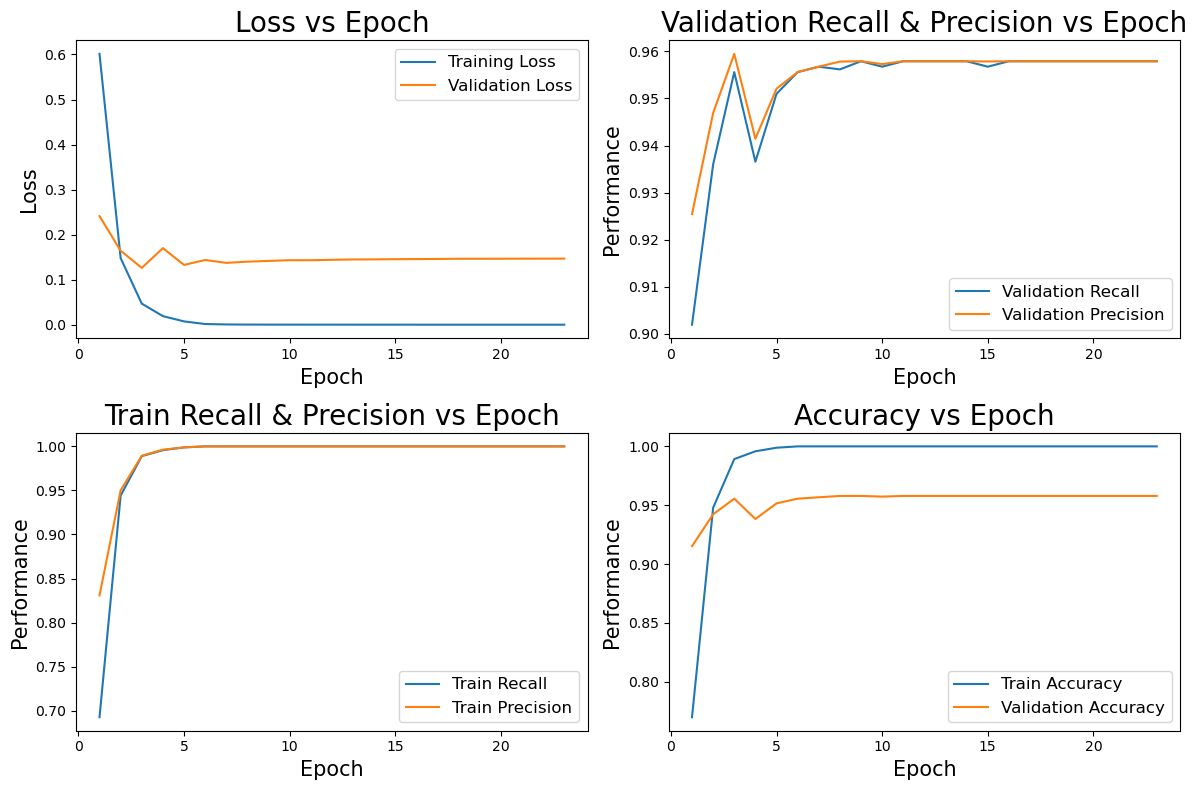

In [10]:
from functions import view_history, train_model, model_evaluate

# Define dictionary to store history
conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version1')

In [11]:
# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

 3/54 [>.............................] - ETA: 1s - loss: 0.0172 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1263 - precision: 0.9595 - recall: 0.9556 - accuracy: 0.9556


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.018823,99.841636,99.841636,99.841636
1,Test,0.619112,91.465569,91.143698,91.260999
2,Validation,0.126341,95.946729,95.559400,95.559400


It seems that our might be overfitting or another possibility is that we arent capturing enough of the data complexity. We plateau pretty fast for val_loss but for train_loss the curve seems a little underdeveloped.

**Next Steps**: Increase model complexity to confirm overfit.

# CNN Version 2

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(256, activation='relu'))
cnn2.add(Dense(256, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               67109120  
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 4)                 1028      
                                                      

Epoch 1/50
218/218 [==============================] - 9s 40ms/step - loss: 0.7395 - precision: 0.8437 - recall: 0.7414 - accuracy: 0.7542 - val_loss: 0.2770 - val_precision: 0.9055 - val_recall: 0.8899 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1472 - precision: 0.9473 - recall: 0.9424 - accuracy: 0.9453 - val_loss: 0.2308 - val_precision: 0.9222 - val_recall: 0.9164 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0541 - precision: 0.9830 - recall: 0.9823 - accuracy: 0.9830 - val_loss: 0.1448 - val_precision: 0.9514 - val_recall: 0.9493 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0273 - precision: 0.9925 - recall: 0.9921 - accuracy: 0.9924 - val_loss: 0.1505 - val_precision: 0.9508 - val_recall: 0.9481 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 5/50
218/218 [============================

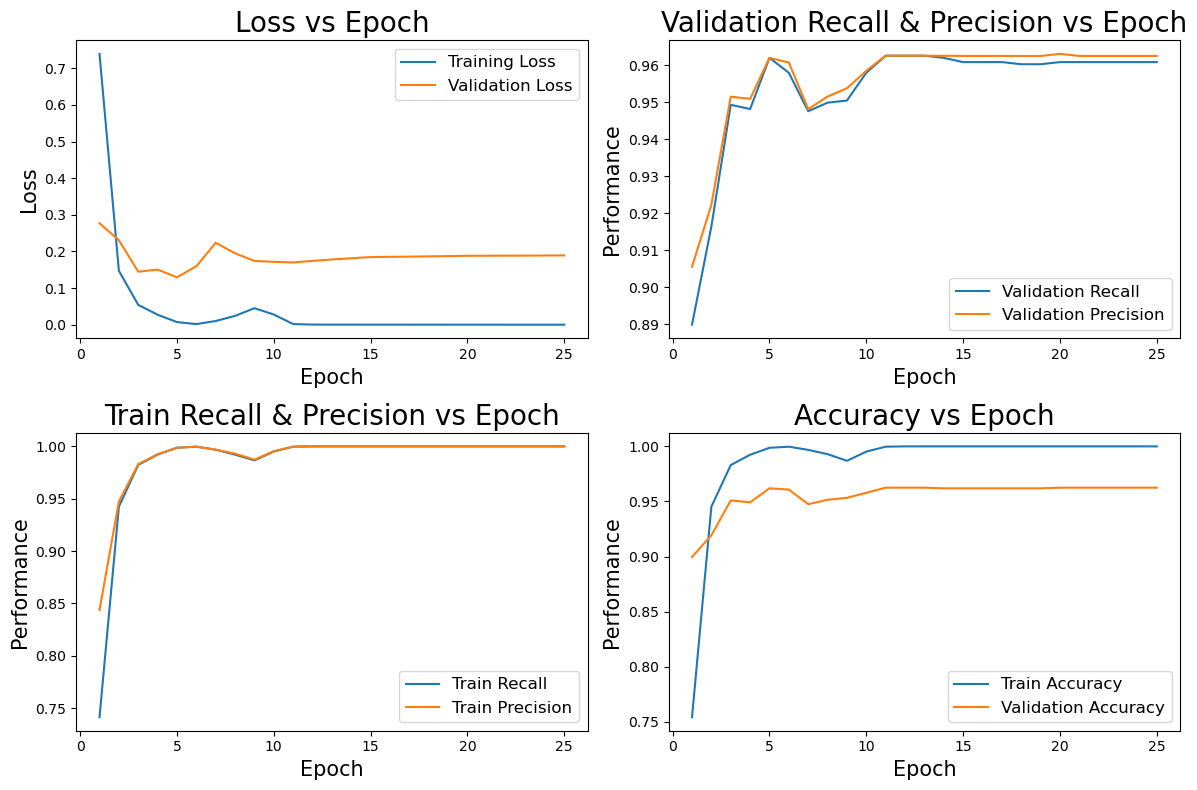

 3/54 [>.............................] - ETA: 1s - loss: 0.0243 - precision: 0.9792 - recall: 0.9792 - accuracy: 0.9792

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.1294 - precision: 0.9619 - recall: 0.9619 - accuracy: 0.9619


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.001495,99.956810,99.956810,99.956810
1,Test,1.145440,90.733141,90.733141,90.733141
2,Validation,0.129434,96.193773,96.193773,96.193773


In [13]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

Increasing the complexity of the Convolutional layer caused us to overfit. This is also true for increasing neurons.

**Next Steps**: keep the same complexity from the base as our train curve is better but introduce regularization

# CNN Version 4

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn4 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn4.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn4.add(Flatten())
cnn4.add(Dense(64, activation='relu'))

# Define the output 
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 64)                4194368   
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,195,076
Trainable params: 4,195,076
Non-trainable params: 0
____________________________________________

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 0.7212 - precision: 0.8375 - recall: 0.7364 - accuracy: 0.7468 - val_loss: 0.3196 - val_precision: 0.9028 - val_recall: 0.8627 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2406 - precision: 0.9256 - recall: 0.9057 - accuracy: 0.9158 - val_loss: 0.2654 - val_precision: 0.9156 - val_recall: 0.8818 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1237 - precision: 0.9641 - recall: 0.9580 - accuracy: 0.9623 - val_loss: 0.1638 - val_precision: 0.9472 - val_recall: 0.9412 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0625 - precision: 0.9837 - recall: 0.9813 - accuracy: 0.9830 - val_loss: 0.1343 - val_precision: 0.9606 - val_recall: 0.9550 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 5/50
218/218 [============================

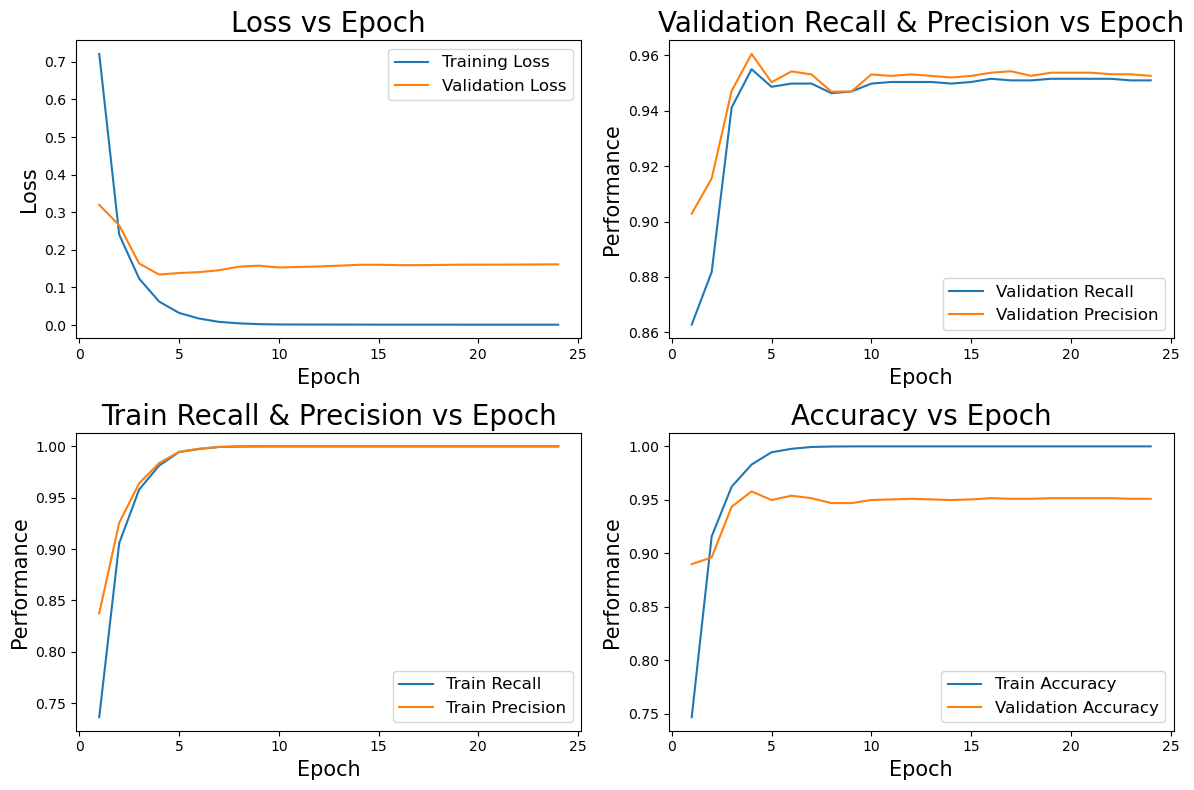

 3/54 [>.............................] - ETA: 1s - loss: 0.0265 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1343 - precision: 0.9606 - recall: 0.9550 - accuracy: 0.9579


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.035124,99.682903,99.568099,99.654478
1,Test,0.779070,89.323843,88.328445,88.739002
2,Validation,0.134255,96.055686,95.501733,95.790082


In [15]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version4'] = train_model(cnn4, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version4')

# Evalaute model
model_evaluate(cnn4, train_gen, test_gen, val_gen)

Reducing model complexity didnt help. We perform about the same. Our losses are about the same. We need to introduce regualrization and we need to introduce more convolutional layers.

**Next Steps**: Introduce regularization and introduce another Convolutinal layer to attempt gaining more information.

# CNN Version 5

In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn5 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn5.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))
cnn5.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn5.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn5.add(Flatten())
cnn5.add(Dense(256, activation='relu'))
cnn5.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn5.add(Dense(4, activation='softmax'))

cnn5.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn5.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)              

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 1.3273 - precision: 0.8496 - recall: 0.7150 - accuracy: 0.7446 - val_loss: 0.5723 - val_precision: 0.8869 - val_recall: 0.8685 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4292 - precision: 0.8993 - recall: 0.8842 - accuracy: 0.8925 - val_loss: 0.3283 - val_precision: 0.9244 - val_recall: 0.9164 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2170 - precision: 0.9543 - recall: 0.9493 - accuracy: 0.9521 - val_loss: 0.2110 - val_precision: 0.9514 - val_recall: 0.9487 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1184 - precision: 0.9764 - recall: 0.9758 - accuracy: 0.9762 - val_loss: 0.1880 - val_precision: 0.9579 - val_recall: 0.9573 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/50
218/218 [============================

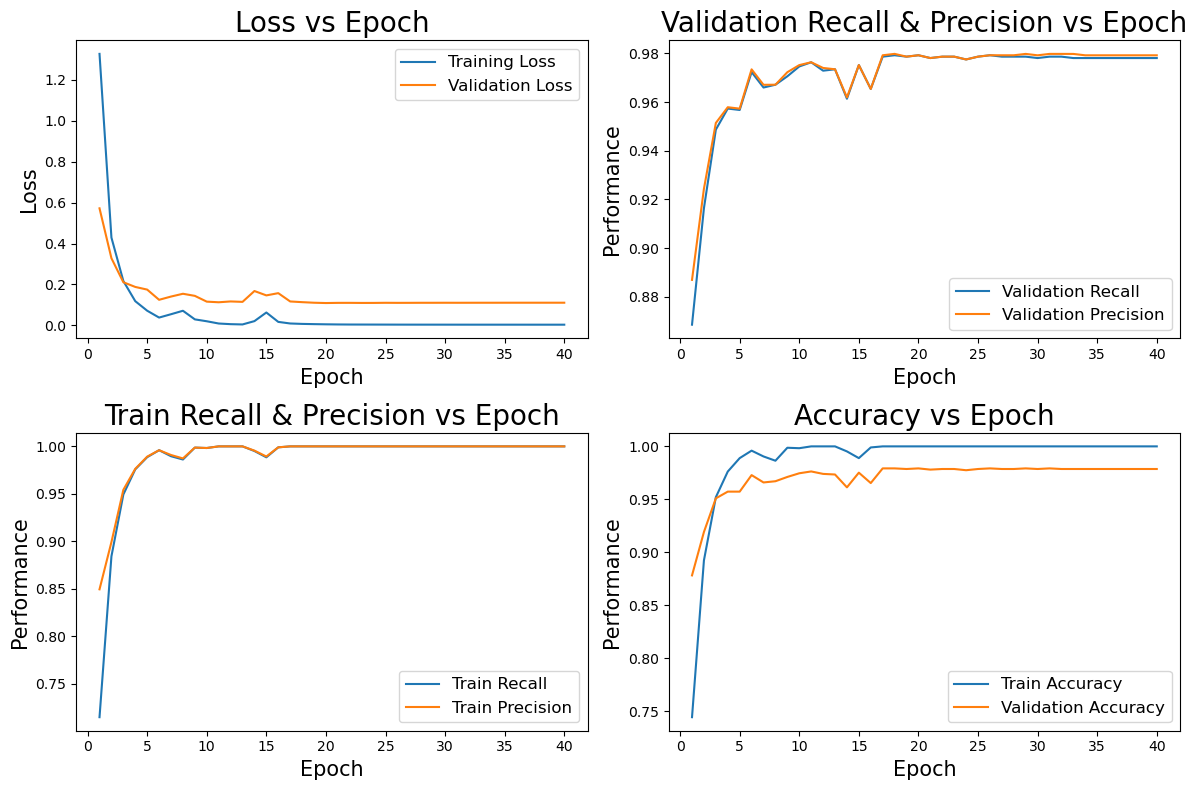

 3/54 [>.............................] - ETA: 1s - loss: 0.0048 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1093 - precision: 0.9792 - recall: 0.9792 - accuracy: 0.9792


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.004880,100.000000,100.000000,100.000000
1,Test,0.717550,92.126912,91.964811,91.964811
2,Validation,0.109275,97.923875,97.923875,97.923875


In [17]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version5'] = train_model(cnn5, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version5')

# Evalaute model
model_evaluate(cnn5, train_gen, test_gen, val_gen)

The model is performing better. We should add more regularization now. 

**Next Steps**: Add a Dropout layer.

# CNN Version 6

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn6 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Dropout(.20))

# Flatten Tensor
cnn6.add(Flatten())
cnn6.add(Dense(256, activation='relu'))
cnn6.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn6.add(Dense(4, activation='softmax'))

cnn6.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn6.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 32768)            

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 1.3125 - precision: 0.8498 - recall: 0.7452 - accuracy: 0.7617 - val_loss: 0.5615 - val_precision: 0.8927 - val_recall: 0.8639 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4067 - precision: 0.9104 - recall: 0.8968 - accuracy: 0.9038 - val_loss: 0.2844 - val_precision: 0.9400 - val_recall: 0.9308 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1993 - precision: 0.9607 - recall: 0.9578 - accuracy: 0.9595 - val_loss: 0.2028 - val_precision: 0.9577 - val_recall: 0.9539 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.1267 - precision: 0.9750 - recall: 0.9731 - accuracy: 0.9747 - val_loss: 0.1618 - val_precision: 0.9636 - val_recall: 0.9631 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 5/50
218/218 [============================

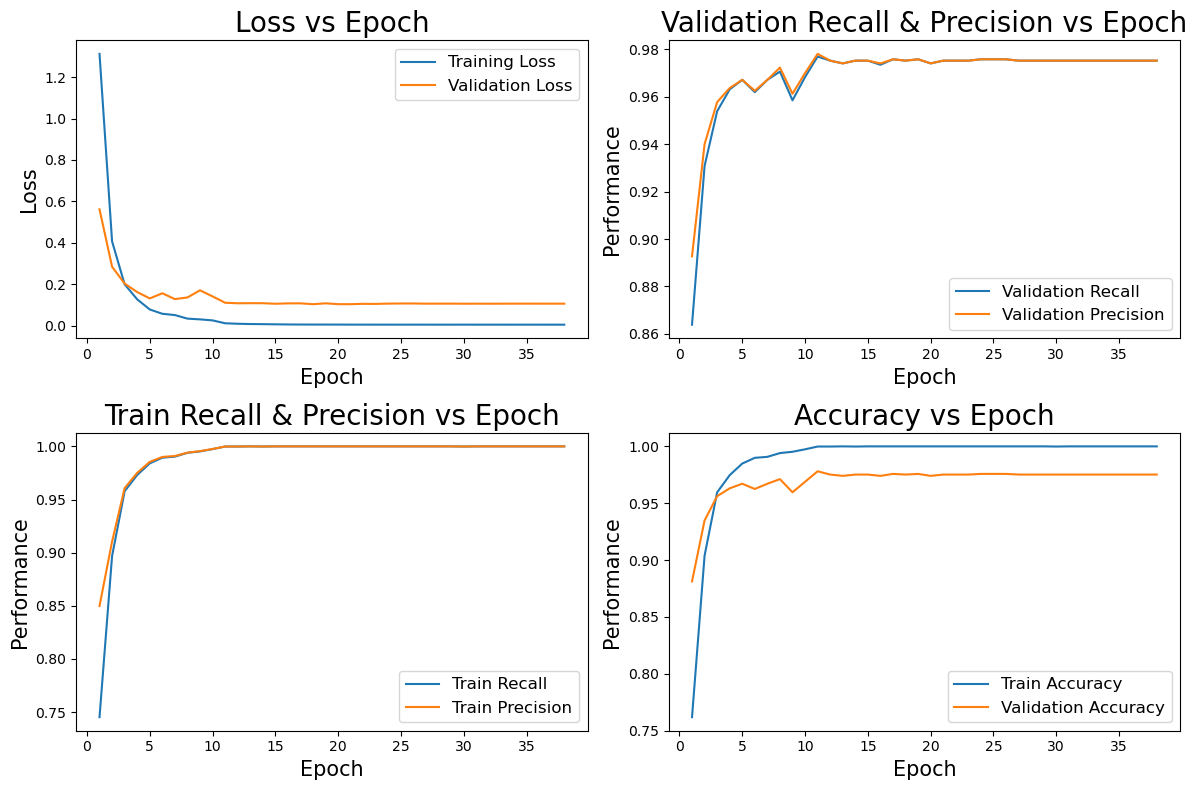

 3/54 [>.............................] - ETA: 1s - loss: 0.0073 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1033 - precision: 0.9752 - recall: 0.9752 - accuracy: 0.9752


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.004531,100.000000,100.000000,100.000000
1,Test,0.787045,92.176473,91.906160,91.964811
2,Validation,0.103281,97.520185,97.520185,97.520185


In [19]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version6'] = train_model(cnn6, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version6')

# Evalaute model
model_evaluate(cnn6, train_gen, test_gen, val_gen)

Adding Dropout before the Dense Layers helped reduce overfit. What we can now is introduce more regularization in hopes to improve val loss and generalization.

**Next Steps:** Increase regularization on drpout.

# CNN Version 7

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn7 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn7.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn7.add(MaxPool2D(pool_size=(2,2)))
cnn7.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn7.add(MaxPool2D(pool_size=(2,2)))
cnn7.add(Dropout(.40))

# Flatten Tensor
cnn7.add(Flatten())
cnn7.add(Dense(256, activation='relu'))
cnn7.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn7.add(Dense(4, activation='softmax'))

cnn7.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn7.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 32768)            

 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 8,465,828
Trainable params: 8,465,828
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 1.3590 - precision: 0.8312 - recall: 0.7051 - accuracy: 0.7236 - val_loss: 0.5979 - val_precision: 0.8799 - val_recall: 0.8362 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4262 - precision: 0.9017 - recall: 0.8845 - accuracy: 0.8945 - val_loss: 0.3711 - val_precision: 0.9019 - val_recall: 0.8904 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2362 - precision: 0.9473 - recall: 0.9411 - accuracy: 0.9447 - val_loss: 0.2093 - val_precision: 0.9546 - val_recall: 0.9464 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1262 - precision: 0.9753 - recall: 0.9738 - accuracy: 0.9744 - val_loss: 0.1551 - val_precision: 0.9665 - val_recall: 0.9660 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 5/50
218/218 [============================

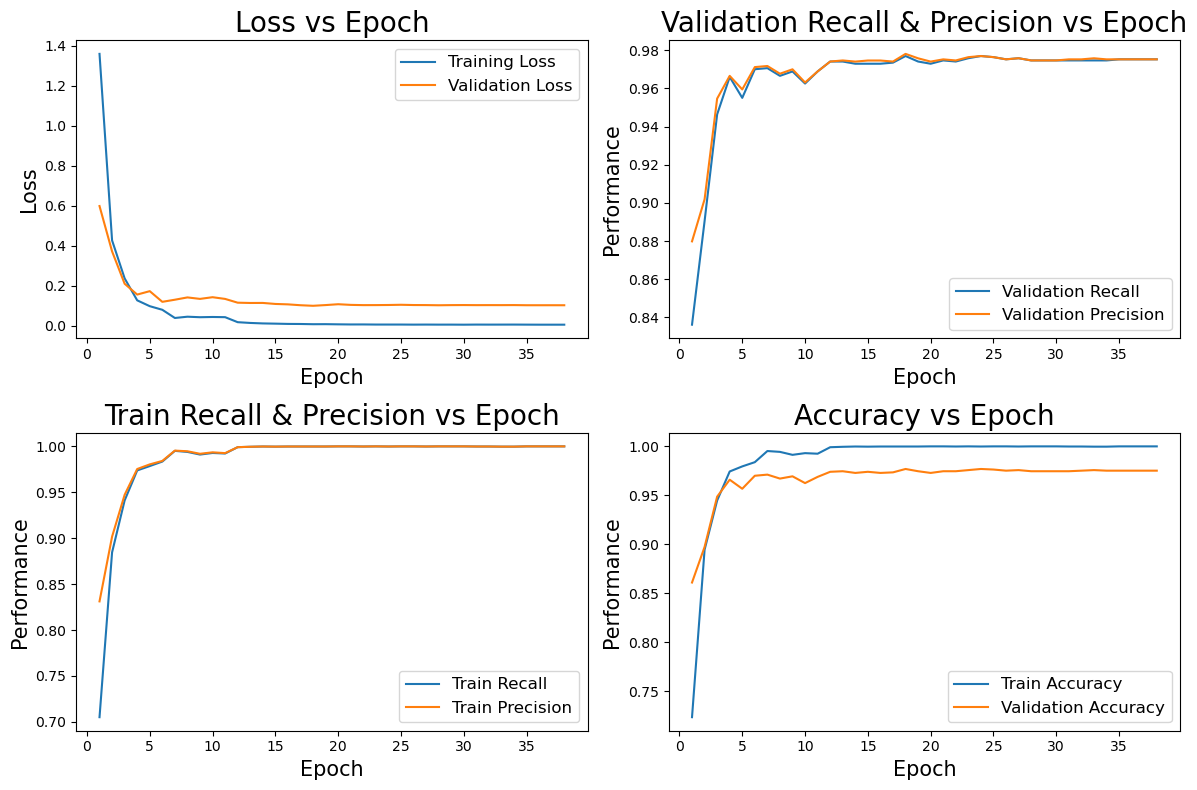

 3/54 [>.............................] - ETA: 1s - loss: 0.0055 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0990 - precision: 0.9781 - recall: 0.9769 - accuracy: 0.9769


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.005491,100.000000,100.000000,100.000000
1,Test,0.759355,91.813898,91.436952,91.436952
2,Validation,0.099014,97.806007,97.693193,97.693193


In [21]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version7'] = train_model(cnn7, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version7')

# Evalaute model
model_evaluate(cnn7, train_gen, test_gen, val_gen)

It seems we are doing better. The gaps between the curves is closing. Our generalization is slightly better. It seems increasing dropout was not enough. Let increase the l2().

**Next Steps:** Increase l2 regularization

# CNN Version 8

In [22]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn8 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn8.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn8.add(MaxPool2D(pool_size=(2,2)))
cnn8.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn8.add(MaxPool2D(pool_size=(2,2)))
cnn8.add(Dropout(.40))

# Flatten Tensor
cnn8.add(Flatten())
cnn8.add(Dense(256, activation='relu'))
cnn8.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1)))

# Define the output 
cnn8.add(Dense(4, activation='softmax'))

cnn8.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn8.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 32768)            

Total params: 8,465,828
Trainable params: 8,465,828
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
218/218 [==============================] - 9s 39ms/step - loss: 4.6891 - precision: 0.8320 - recall: 0.7153 - accuracy: 0.7293 - val_loss: 0.5715 - val_precision: 0.8434 - val_recall: 0.7953 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.4099 - precision: 0.8794 - recall: 0.8534 - accuracy: 0.8668 - val_loss: 0.3612 - val_precision: 0.8947 - val_recall: 0.8725 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2410 - precision: 0.9378 - recall: 0.9274 - accuracy: 0.9328 - val_loss: 0.2702 - val_precision: 0.9331 - val_recall: 0.9250 - val_accuracy: 0.9302 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1749 - precision: 0.9585 - recall: 0.9545 - accuracy: 0.9567 - val_loss: 0.2179 - val_precision: 0.9434 - val_recall: 0.9331 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 5/50
218/218 [============================

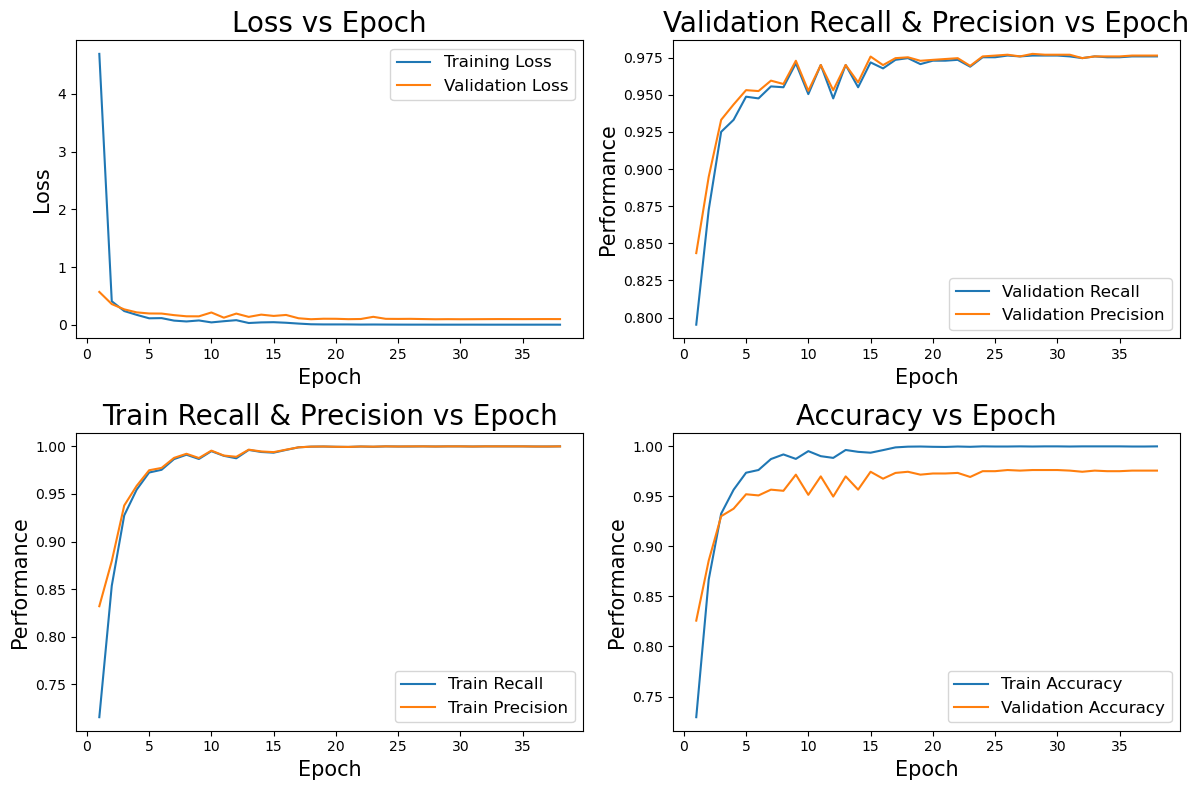

 3/54 [>.............................] - ETA: 1s - loss: 0.0081 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0993 - precision: 0.9752 - recall: 0.9746 - accuracy: 0.9746


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.008911,99.985605,99.985605,99.985605
1,Test,0.566927,92.089731,91.495603,91.495603
2,Validation,0.099313,97.518754,97.462517,97.462517


In [23]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version8'] = train_model(cnn8, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version8')

# Evalaute model
model_evaluate(cnn8, train_gen, test_gen, val_gen)

We are doing better and better but it seems that maybe we can benefit off of an another convolutional layer because we do great in training but our test is 10% lower. We are failing to capture some essential information somewhere in the architecture. Lets addd another Convolutional layer.

**Next Steps**: Add another Convolutional layer. 

# CNN Version 9

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn9 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn9.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn9.add(MaxPool2D(pool_size=(2,2)))
cnn9.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn9.add(MaxPool2D(pool_size=(2,2)))
cnn9.add(Dropout(.40))
cnn9.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn9.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn9.add(Flatten())
cnn9.add(Dense(256, activation='relu'))
cnn9.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1)))

# Define the output 
cnn9.add(Dense(4, activation='softmax'))

cnn9.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn9.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)       

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 4.6115 - precision: 0.8180 - recall: 0.6598 - accuracy: 0.6885 - val_loss: 0.6411 - val_precision: 0.7817 - val_recall: 0.7209 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.5034 - precision: 0.8430 - recall: 0.8032 - accuracy: 0.8277 - val_loss: 0.4759 - val_precision: 0.8848 - val_recall: 0.8103 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.3768 - precision: 0.8890 - recall: 0.8651 - accuracy: 0.8791 - val_loss: 0.3436 - val_precision: 0.9031 - val_recall: 0.8870 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2812 - precision: 0.9192 - recall: 0.9056 - accuracy: 0.9128 - val_loss: 0.3537 - val_precision: 0.9046 - val_recall: 0.8749 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 5/50
218/218 [============================

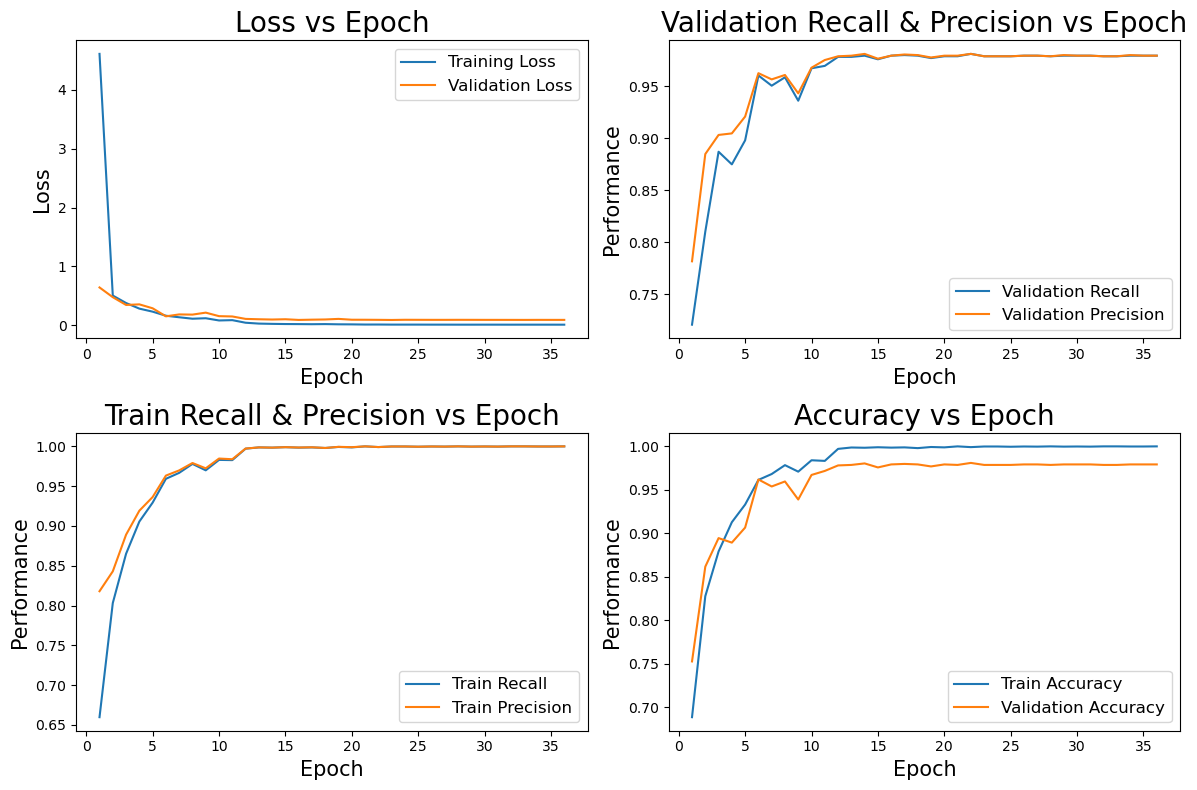

 3/54 [>.............................] - ETA: 1s - loss: 0.0134 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0892 - precision: 0.9792 - recall: 0.9792 - accuracy: 0.9792


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.013313,99.985605,99.985605,99.985605
1,Test,0.623473,92.429578,92.375368,92.375368
2,Validation,0.089242,97.923875,97.923875,97.923875


In [25]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version9'] = train_model(cnn9, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version9')

# Evalaute model
model_evaluate(cnn9, train_gen, test_gen, val_gen)

We are doing even better. Our val loss and metrics are correlating and decreasing with our curves. It seems that we make progress but not by much. To address this we can do a hyperparameter search using Keras Tuner. 

**Next Steps:** Do hyper parameter tuning.

# Hyper parameter tuning

In [9]:
import keras_tuner
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
from functions import get_callbacks
from keras.regularizers import l2

# Create model framework
hp = keras_tuner.HyperParameters()
input_shape = (128, 128, 3)
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

def build_model1(hp=hp, input_shape=input_shape, metrics=metrics):
    # Instatiate model
    model = Sequential()
    
    # Make Convolutional network
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_1', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_1', values=['valid', 'same']),
                    input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_2', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_2', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_1', min_value=.1, max_value=.5, step=.1)))
    model.add(Conv2D(filters=hp.Int('filters_3', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_3', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_3', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    # Flatten Tensor and create Fully conected layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_1', min_value=1, max_value=256, step=31), 
                    activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=1, max_value=256, step=31), 
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('regularization_factor', min_value=1e-5, max_value=.3, sampling='log'))))
    
    # Create output layer
    model.add(Dense(units=4, activation='softmax'))
    
    # Define optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Compile model
    model.compile(optimizer=optimizer_choice,
                loss=CategoricalCrossentropy(),
                metrics=metrics)
    
    return model

# Create directory to save trail data 
tuner_directory = "trials/"

if not os.path.exists(tuner_directory):
    os.makedirs(tuner_directory)
    print(f"Directory '{tuner_directory}' created.")
else:
    print(f"Directory '{tuner_directory}' already exists.")

# Define the tuner/search strategy
tuner = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective='val_loss',
    max_epochs=8,
    directory=tuner_directory,
    project_name='my_hyperband_project1',
    seed=42
)

# Tuner.search uses same param as .fit()
tuner.search(train_gen,
            epochs=50,
            validation_data=val_gen,
            callbacks=[get_callbacks()])

# Run the hyperparameter search
tuner.search(train_gen, epochs=2, validation_data=val_gen, callbacks=get_callbacks())

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 10 Complete [00h 01m 48s]
val_loss: 0.18509747087955475

Best val_loss So Far: 0.08009544014930725
Total elapsed time: 00h 12m 31s


In [10]:
# View the model
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 240)     6720      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 240)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 80)        1920080   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 80)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 27, 80)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 208)      

In [11]:
print(best_hyperparameters.values)

{'filters_1': 240, 'kernel_size_1': 3, 'padding_1': 'valid', 'filters_2': 80, 'kernel_size_2': 10, 'padding_2': 'valid', 'droprate_1': 0.2, 'filters_3': 208, 'kernel_size_3': 10, 'padding_3': 'valid', 'units_1': 63, 'units_2': 125, 'regularization_factor': 4.445611039057308e-05, 'optimizer': 'adam', 'tuner/epochs': 8, 'tuner/initial_epoch': 3, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0002'}


Epoch 1/50
218/218 [==============================] - 27s 119ms/step - loss: 0.8571 - precision: 0.7477 - recall: 0.4965 - accuracy: 0.6310 - val_loss: 0.5141 - val_precision: 0.8371 - val_recall: 0.7618 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 25s 117ms/step - loss: 0.4581 - precision: 0.8382 - recall: 0.7918 - accuracy: 0.8166 - val_loss: 0.3086 - val_precision: 0.8849 - val_recall: 0.8599 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 25s 115ms/step - loss: 0.3389 - precision: 0.8864 - recall: 0.8546 - accuracy: 0.8697 - val_loss: 0.2820 - val_precision: 0.9048 - val_recall: 0.8875 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 25s 115ms/step - loss: 0.2090 - precision: 0.9255 - recall: 0.9159 - accuracy: 0.9208 - val_loss: 0.2109 - val_precision: 0.9275 - val_recall: 0.9146 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 5/50
218/218 [====================

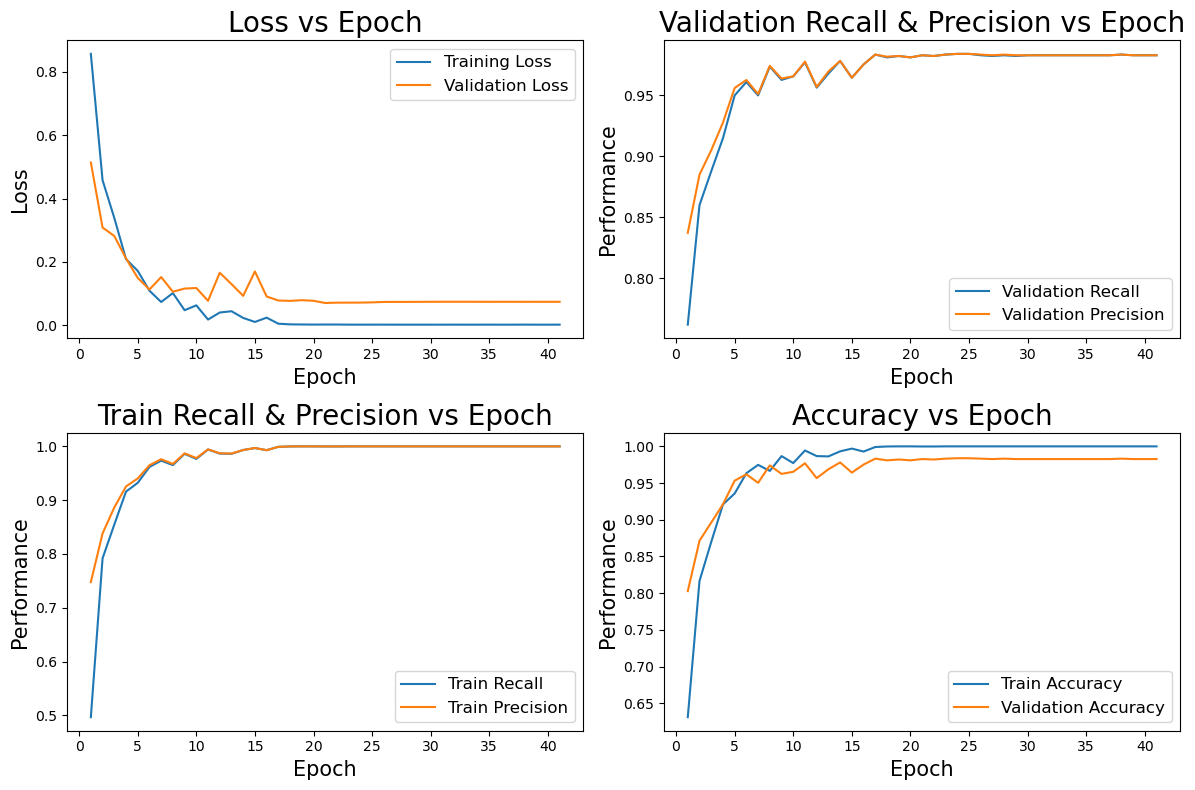

 3/54 [>.............................] - ETA: 1s - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0702 - precision: 0.9827 - recall: 0.9827 - accuracy: 0.9827


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.001765,100.000000,100.000000,100.000000
1,Test,1.335305,92.727274,92.727274,92.727274
2,Validation,0.070188,98.269898,98.269898,98.269898


In [13]:
from functions import train_model, view_history, model_evaluate
conv = {}

conv['Version10'] = train_model(best_model, train_gen, val_gen, 50)

view_history(conv, 'Version10')

model_evaluate(best_model, train_gen, test_gen, val_gen)

In [14]:
from keras.models import save_model

save_model(best_model, "models/model1.keras")

As we can see our train loss and val loss are much closer overall in this optimized version. This is a good thing as it allows for good generalization. We seem to perform about the same for testing images no matter what we do. We need to take this trained model and train it on augmented data. 

# Augmentation

In [15]:
from functions import data_augmentation
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Obtain data generators
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir=train_data_dir, test_data_dir=test_data_dir, val_data_dir=val_data_dir)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


In [16]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen_aug.class_indices
val_class_labels = train_gen_aug.class_indices
test_class_labels = val_gen_aug.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Test Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


Image dimensions: (128, 128, 3)


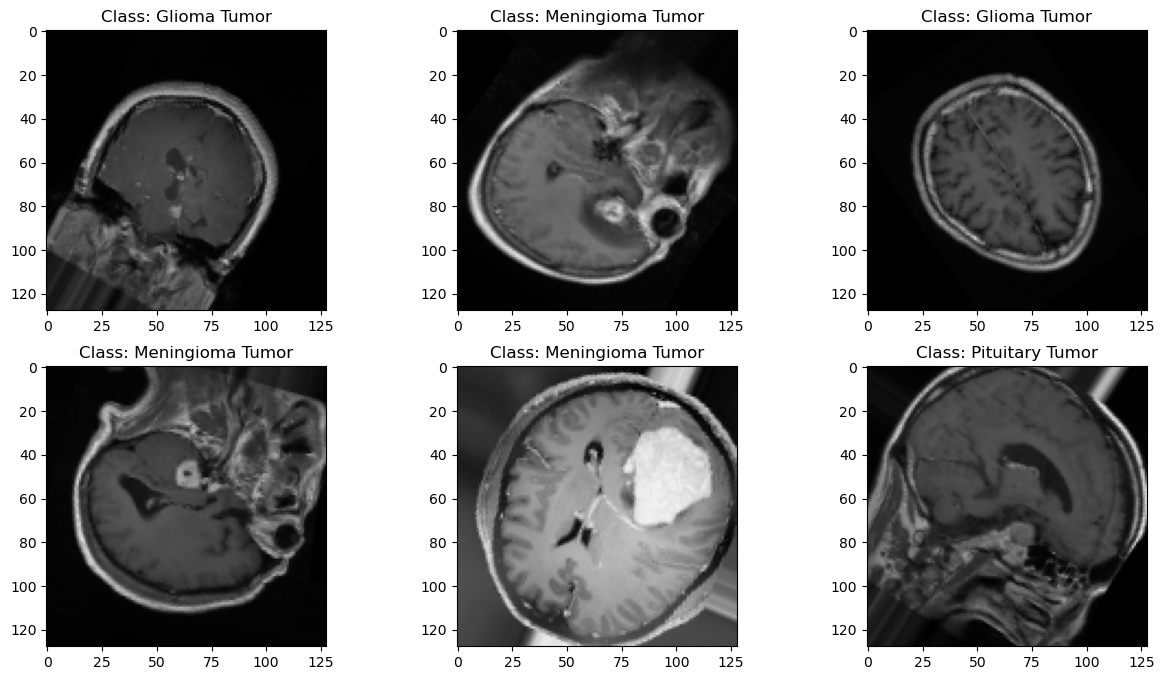

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve one batch of images from the generator
images, labels = train_gen_aug.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'Glioma Tumor': 0, 'Meningioma Tumor': 1, 'No Tumor': 2, 'Pituitary Tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

Epoch 1/100
218/218 [==============================] - 30s 134ms/step - loss: 2.8484 - precision: 0.6486 - recall: 0.6424 - accuracy: 0.6453 - val_loss: 2.7390 - val_precision: 0.6552 - val_recall: 0.6488 - val_accuracy: 0.6522 - lr: 6.4000e-08
Epoch 2/100
218/218 [==============================] - 29s 133ms/step - loss: 2.8811 - precision: 0.6540 - recall: 0.6473 - accuracy: 0.6513 - val_loss: 2.8816 - val_precision: 0.6523 - val_recall: 0.6471 - val_accuracy: 0.6517 - lr: 6.4000e-08
Epoch 3/100
218/218 [==============================] - 29s 131ms/step - loss: 2.8685 - precision: 0.6531 - recall: 0.6474 - accuracy: 0.6512 - val_loss: 2.9426 - val_precision: 0.6579 - val_recall: 0.6499 - val_accuracy: 0.6528 - lr: 6.4000e-08
Epoch 4/100
218/218 [==============================] - 29s 131ms/step - loss: 2.7951 - precision: 0.6655 - recall: 0.6575 - accuracy: 0.6607 - val_loss: 2.9074 - val_precision: 0.6506 - val_recall: 0.6401 - val_accuracy: 0.6436 - lr: 6.4000e-08
Epoch 5/100
218/218 

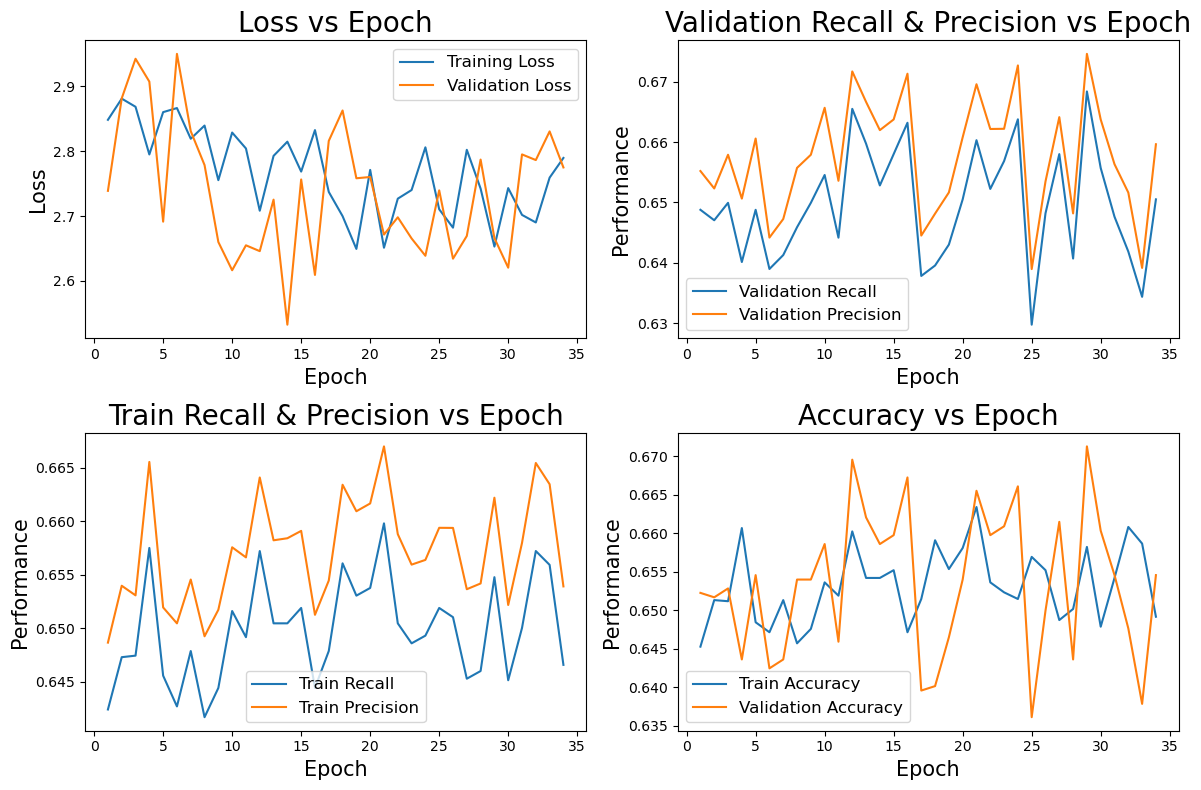

 3/54 [>.............................] - ETA: 1s - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 5s 92ms/step - loss: 2.7779 - precision: 0.6618 - recall: 0.6546 - accuracy: 0.6592


,Set,Loss,Precision,Recall,Accuracy
0,Train,2.810666,65.508723,64.886266,65.188599
1,Test,1.296843,92.785925,92.785925,92.785925
2,Validation,2.777912,66.180760,65.455592,65.916955


In [18]:
from keras.models import load_model
from functions import train_model, model_evaluate, view_history

# Load the model 
model1 = load_model("models/model1.keras")

# Apply data augmentation on saved model
aug = {}

# Train the model and save history
aug["Version1"] = train_model(model1, train_generator=train_gen_aug, val_gen=val_gen_aug, total_epochs=100)

# View the History
view_history(aug, "Version1")

# Evaluate model
model_evaluate(model1, train_gen=train_gen_aug, test_gen=test_gen_aug, val_gen=val_gen_aug)

In [19]:
from functions import model_evaluate, process_data

train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir=train_data_dir, test_data_dir=test_data_dir, val_data_dir=val_data_dir)

# Evaluate model on original data
model_evaluate(model1, train_gen=train_gen, test_gen=test_gen, val_gen=val_gen)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.
 3/54 [>.............................] - ETA: 2s - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0715 - precision: 0.9827 - recall: 0.9827 - accuracy: 0.9827


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.001786,100.000000,100.000000,100.000000
1,Test,1.296843,92.785925,92.785925,92.785925
2,Validation,0.071460,98.269898,98.269898,98.269898


In [20]:
from keras.models import save_model

save_model(model1, "models/model1_aug.keras")

It seems that we did learn a bit more with augmented data. It was not a huge performance increase but now we generalize slightly better since we had more data. We can tell we generalized better because ouy val_loss and train loss are closer to eachother and so are the metrics. Lets view a confusion matrix on the test set. 

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the number of samples in the test set
num_samples = len(test_gen)

# Initialize empty arrays to collect true labels
true_labels_all = []
predicted_labels_all = []

# Iterate over all batches in the test set
for i in range(num_samples):
    # Generate the next batch
    images, labels = test_gen.next()
    
    # Get true labels (assuming labels are one-hot encoded)
    true_labels = np.argmax(labels, axis=1)
    
    # Get predictions and labels from test set
    predictions = model1.predict(images)

    # Get the predicted labels
    predicted_labels = predictions.argmax(axis=1)
    
    # Append true and predicted labels to the lists
    true_labels_all.extend(true_labels)
    predicted_labels_all.extend(predicted_labels)


# Convert lists to numpy arrays for confusion matrix calculation
true_labels_all = np.array(true_labels_all)
predicted_labels_all = np.array(predicted_labels_all)

1/1 [==============================] - 0s 50ms/step


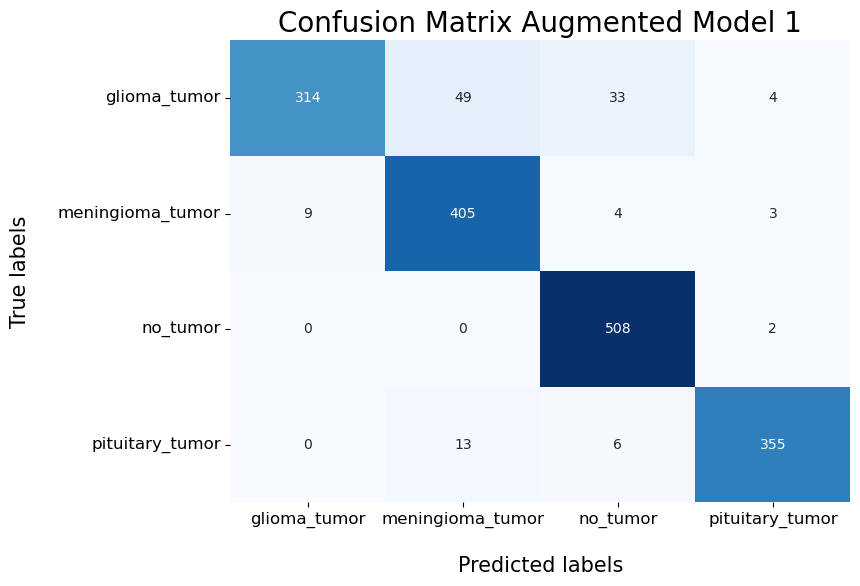

In [23]:
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_true=true_labels_all, y_pred=predicted_labels_all)

# Visualize confusion matrix 
title = 20
label = 15
ticks = 12

plt.figure(figsize=(8, 6), facecolor='white')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], 
            yticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], 
            annot_kws={"fontsize": 10}, 
            cbar=False)
plt.xlabel('Predicted labels', labelpad=20, fontsize=label)
plt.xticks(fontsize=ticks)
plt.ylabel('True labels', labelpad=20, fontsize=label)
plt.yticks(fontsize=ticks)
plt.title('Confusion Matrix Augmented Model 1', fontsize=title)
plt.show()

# Improving Generalization

Although we made a good model it can be better. The metrics are good on unknown data but we still see some overfit occuring. Lets attempt to address this by adding another Dropout layer.

In [61]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnna = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnna.add(Conv2D(filters=64, kernel_size=(10, 10), strides=(1,1), activation='relu', padding='same', input_shape=input_shape))
cnna.add(MaxPool2D(pool_size=(2,2)))
cnna.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
cnna.add(MaxPool2D(pool_size=(2,2)))
cnna.add(Dropout(.2))
cnna.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
cnna.add(MaxPool2D(pool_size=(2,2)))
cnna.add(Dropout(.2))

# Flatten Tensor and create Fully conected layer
cnna.add(Flatten())
cnna.add(Dense(256, activation='relu'))

# Define the output layer 
cnna.add(Dense(4, activation='softmax'))

cnna.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnna.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)      

Epoch 1/50
218/218 [==============================] - 10s 40ms/step - loss: 0.7816 - precision: 0.8164 - recall: 0.6583 - accuracy: 0.6797 - val_loss: 0.5561 - val_precision: 0.7869 - val_recall: 0.7157 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.3915 - precision: 0.8616 - recall: 0.8284 - accuracy: 0.8457 - val_loss: 0.2784 - val_precision: 0.9012 - val_recall: 0.8841 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2087 - precision: 0.9239 - recall: 0.9158 - accuracy: 0.9205 - val_loss: 0.1685 - val_precision: 0.9456 - val_recall: 0.9418 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.1350 - precision: 0.9506 - recall: 0.9477 - accuracy: 0.9493 - val_loss: 0.1450 - val_precision: 0.9509 - val_recall: 0.9487 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 5/50
218/218 [===========================

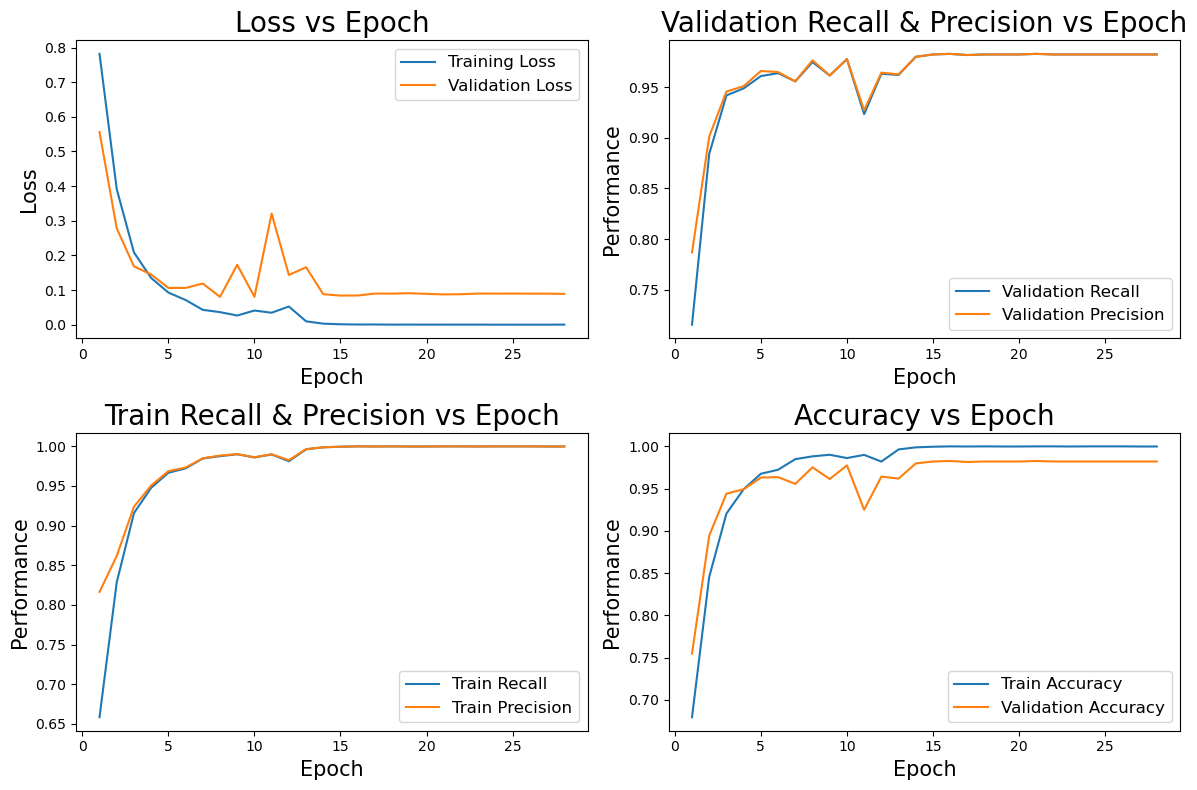

 3/54 [>.............................] - ETA: 1s - loss: 0.0088 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0805 - precision: 0.9763 - recall: 0.9746 - accuracy: 0.9752


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.014210,99.611175,99.582493,99.611288
1,Test,1.627100,91.074574,90.967745,90.967745
2,Validation,0.080459,97.631425,97.462517,97.520185


In [62]:
from functions import train_model, view_history, model_evaluate

pub = {}

# Train model
pub['Version1'] = train_model(cnna, train_gen, val_gen, 50)

# View history 
view_history(pub, 'Version1')

# Evalaute model
model_evaluate(cnna, train_gen, test_gen, val_gen)

This framework seemed to work very well. We just need to fine tune the model by doing a hyperparam search. Fine tuning will probably help with that overfit 

# Hyperparameter Tuning Publication

In [63]:
import keras_tuner
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
from functions import get_callbacks
from keras.regularizers import l2
from tqdm import tqdm

# Create model framework
hp = keras_tuner.HyperParameters()
input_shape = (128, 128, 3)
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

def build_model2(hp=hp, input_shape=input_shape, metrics=metrics):
    # Instatiate model
    model = Sequential()
    
    # Make Convolutional network
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_1', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding)_1', values=['valid', 'same']),
                    input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_2', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_2', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_1', min_value=.1, max_value=.5, step=.1)))
    model.add(Conv2D(filters=hp.Int('filters_3', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_3', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_3', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_2', min_value=.1, max_value=.5, step=.1)))
    
    # Flatten Tensor and create Fully conected layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_1', min_value=1, max_value=256, step=32), 
                    activation='relu'))
    model.add(Dropout(hp.Float('droprate_3', min_value=0, max_value=.5, step=.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=1, max_value=256, step=32), 
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('regularization_factor', min_value=1e-5, max_value=.3, sampling='log'))))
    
    # Create output layer
    model.add(Dense(units=4, activation='softmax'))
    
    # Define optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Compile model
    model.compile(optimizer=optimizer_choice,
                loss=CategoricalCrossentropy(),
                metrics=metrics)
    
    return model

# Create directory to save trail data 
tuner_directory = "trials/"

if not os.path.exists(tuner_directory):
    os.makedirs(tuner_directory)
    print(f"Directory '{tuner_directory}' created.")
else:
    print(f"Directory '{tuner_directory}' already exists.")

# Define the tuner/search strategy
tuner2 = keras_tuner.Hyperband(
    hypermodel=build_model2,
    objective='val_loss',
    max_epochs=8,
    directory=tuner_directory,
    project_name='my_hyperband_project2',
    seed=42
)

# Run the hyperparameter search
tuner2.search(train_gen, epochs=8, validation_data=val_gen, callbacks=get_callbacks())

# Retrieve the best hyperparameters
best_hyperparameters2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

# Build the final model
best_model2 = tuner2.hypermodel.build(best_hyperparameters2)

Trial 10 Complete [00h 01m 08s]
val_loss: 0.6675748229026794

Best val_loss So Far: 0.15694305300712585
Total elapsed time: 00h 11m 25s


In [64]:
# View the model
best_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 144)     576       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 144)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 240)       864240    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 240)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 240)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 144)      

In [65]:
print(best_hyperparameters.values)

{'filters_1': 144, 'kernel_size_1': 1, 'padding_1': 'same', 'filters_2': 240, 'kernel_size_2': 5, 'padding_2': 'valid', 'droprate_1': 0.5, 'filters_3': 144, 'kernel_size_3': 5, 'padding_3': 'valid', 'droprate_2': 0.2, 'units_1': 125, 'droprate_3': 0.2, 'units_2': 187, 'regularization_factor': 0.003780517668736628, 'optimizer': 'adam', 'tuner/epochs': 8, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Epoch 1/50


218/218 [==============================] - 15s 66ms/step - loss: 1.0037 - precision: 0.7668 - recall: 0.5482 - accuracy: 0.6625 - val_loss: 0.6109 - val_precision: 0.8514 - val_recall: 0.7734 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 14s 64ms/step - loss: 0.5685 - precision: 0.8473 - recall: 0.7946 - accuracy: 0.8255 - val_loss: 0.4600 - val_precision: 0.8733 - val_recall: 0.8426 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 14s 64ms/step - loss: 0.4118 - precision: 0.8846 - recall: 0.8595 - accuracy: 0.8732 - val_loss: 0.3306 - val_precision: 0.9140 - val_recall: 0.8893 - val_accuracy: 0.9066 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 14s 64ms/step - loss: 0.3082 - precision: 0.9131 - recall: 0.8984 - accuracy: 0.9066 - val_loss: 0.3008 - val_precision: 0.9089 - val_recall: 0.8973 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/50
218/218 [==============================] - 1

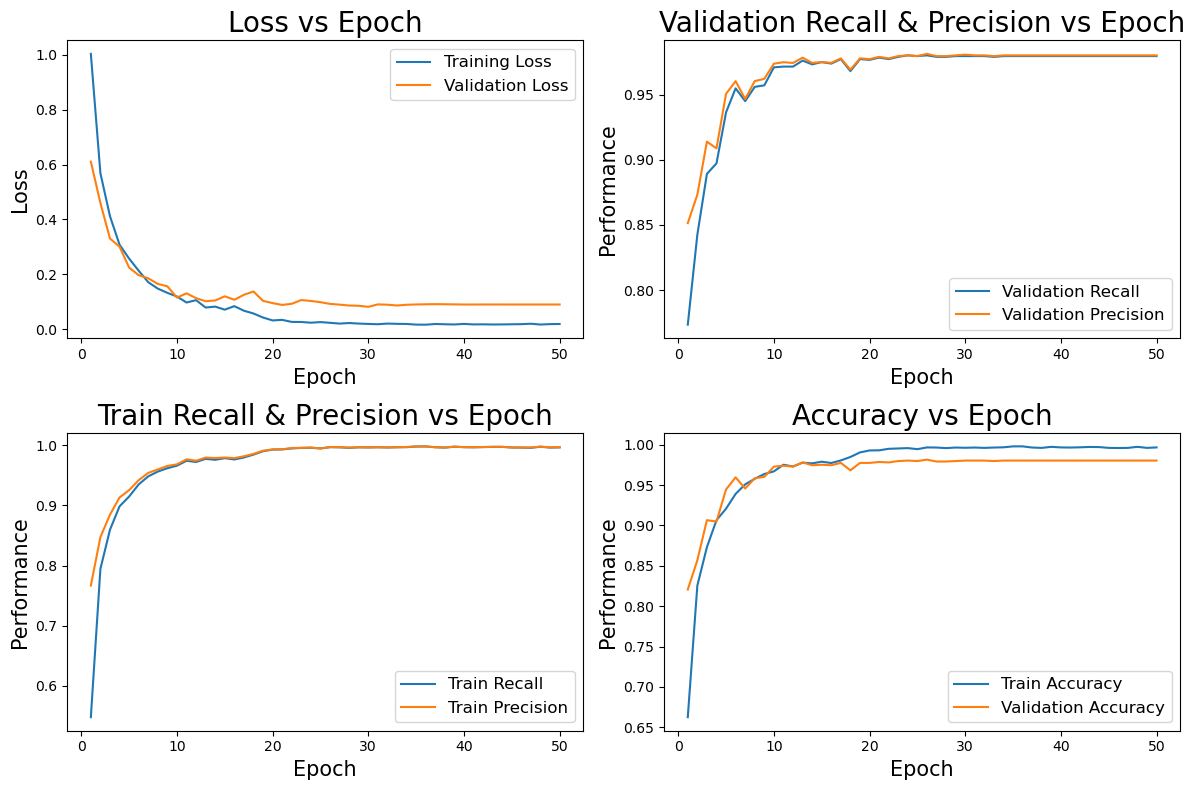

 3/54 [>.............................] - ETA: 1s - loss: 0.0097 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0816 - precision: 0.9809 - recall: 0.9798 - accuracy: 0.9804


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.009992,100.000000,100.000000,100.000000
1,Test,1.010834,92.601293,92.492670,92.609972
2,Validation,0.081577,98.094690,97.981548,98.039216


In [66]:
from functions import train_model, view_history, model_evaluate

pub['Version2'] = train_model(best_model2, train_gen, val_gen, 50)

view_history(pub, 'Version2')

model_evaluate(best_model2, train_gen, test_gen, val_gen)

Turns out our hyperparmater search increases performance as our val loss overall is better and so are the gaps between the model loss curves. The accuracies are not too far from eachother which is good. 

Even the test metrics are much better. We have about 10% increase on both precision and recall. 

Lets attempt data augmentation to train the already trained model 

In [67]:
from keras.models import save_model
import os 

# Specify the path 
directory = 'models/'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

print("Saved model")

# Save the model
save_model(best_model, "models/optimized.keras")

Directory 'models/' already exists.
Saved model


# Data Augmentation Publication

In [68]:
from functions import data_augmentation
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Create data augmented generators
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_folder, test_folder, val_folder)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


Epoch 1/100
218/218 [==============================] - 27s 120ms/step - loss: 2.8495 - precision: 0.6468 - recall: 0.6394 - accuracy: 0.6432 - val_loss: 2.1602 - val_precision: 0.6669 - val_recall: 0.6534 - val_accuracy: 0.6603 - lr: 6.4000e-08
Epoch 2/100
218/218 [==============================] - 25s 115ms/step - loss: 2.9108 - precision: 0.6435 - recall: 0.6345 - accuracy: 0.6399 - val_loss: 2.2265 - val_precision: 0.6557 - val_recall: 0.6448 - val_accuracy: 0.6517 - lr: 6.4000e-08
Epoch 3/100
218/218 [==============================] - 25s 114ms/step - loss: 2.7018 - precision: 0.6525 - recall: 0.6438 - accuracy: 0.6480 - val_loss: 2.2209 - val_precision: 0.6724 - val_recall: 0.6592 - val_accuracy: 0.6638 - lr: 6.4000e-08
Epoch 4/100
218/218 [==============================] - 25s 115ms/step - loss: 2.7731 - precision: 0.6565 - recall: 0.6464 - accuracy: 0.6517 - val_loss: 2.3225 - val_precision: 0.6750 - val_recall: 0.6661 - val_accuracy: 0.6707 - lr: 6.4000e-08
Epoch 5/100
218/218 

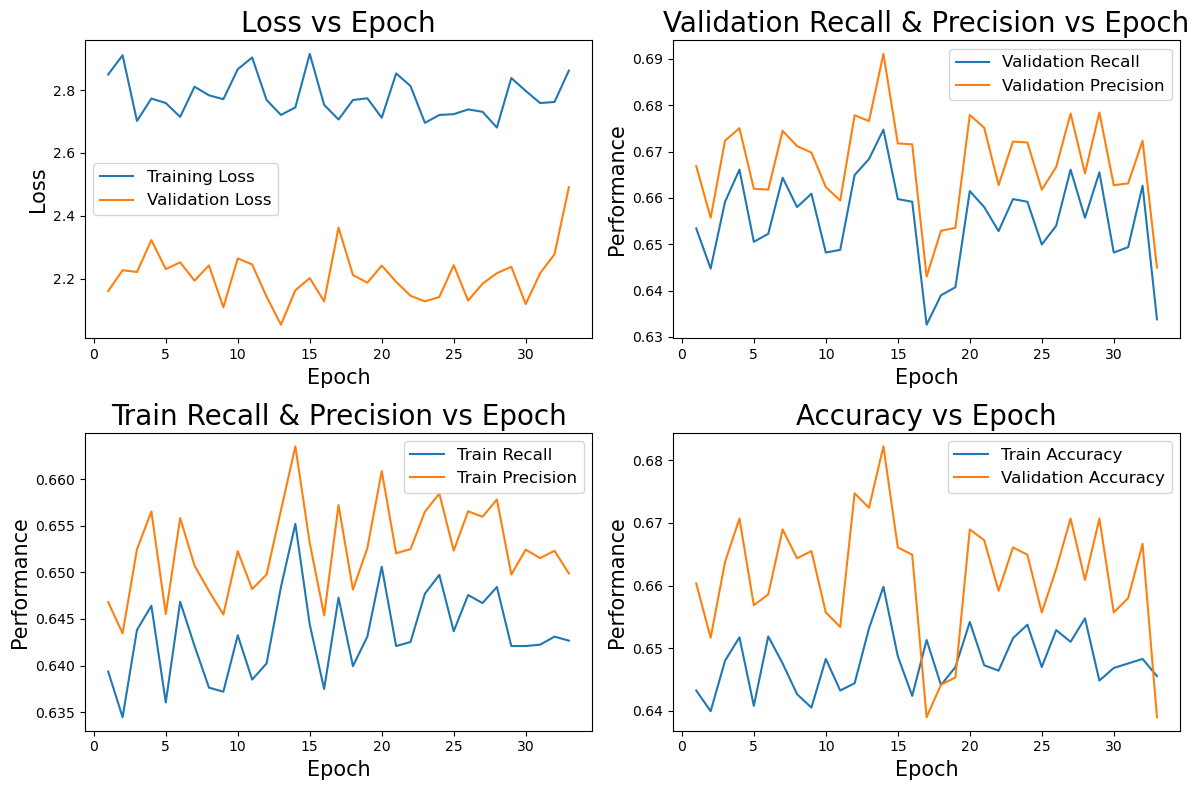

 3/54 [>.............................] - ETA: 1s - loss: 0.0137 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 5s 91ms/step - loss: 2.3334 - precision: 0.6673 - recall: 0.6522 - accuracy: 0.6615


,Set,Loss,Precision,Recall,Accuracy
0,Train,2.154217,67.667741,66.498703,67.074573
1,Test,0.843188,92.185664,92.023462,92.199415
2,Validation,2.333444,66.725665,65.224916,66.147637


In [69]:
from functions import train_model, view_history, model_evaluate
from keras.models import load_model

# Load model
model_pub = load_model("models/optimized.keras")

# Instantiate dictionary
aug_pub = {}

# Train model
aug_pub['Version1'] = train_model(model_pub, train_gen_aug, val_gen_aug, 100)

# View training history 
view_history(aug_pub, 'Version1')

# Evaluate model
model_evaluate(model_pub, train_gen_aug, test_gen_aug, val_gen_aug)

In [70]:
# Evaluate model on original images
model_evaluate(model_pub, train_gen, test_gen, val_gen)

 3/54 [>.............................] - ETA: 1s - loss: 0.0137 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0881 - precision: 0.9809 - recall: 0.9787 - accuracy: 0.9798


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.010844,100.000000,100.000000,100.000000
1,Test,0.843188,92.185664,92.023462,92.199415
2,Validation,0.088067,98.092484,97.866207,97.981548


We kind of see an issue here where it seems that the relu activation function caused lots of dead neurons. We know that because our Recall is terrible. Now on the bright side the test loss is so much better meaning there is better generalization. Our loss curves also look very good. 